In [10]:
import os

arrays_folder = r"i:/SpineUs/2024_Segmentation/02_PreparedArrays"
slices_folder = r"i:/SpineUs/2024_Segmentation/04_Slices"

num_samples = 5
random_seed = 42

In [11]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# Give wider space to print the dataframes
pd.set_option('display.width', 1000)

# Scan the arrays folder and make a df of all files in it that follow this filename pattern: {patient_id}_{orientation}_{image_type}.npy,
# where image_type is either "ultrasound", "segmentation" or "transform".
# The df should have the following columns: patient_id, ultrasound_file, segmentation_file, transform_file.
# If any file types are missing, the corresponding column should be None.
# The df should only have one row for each patient_id.

def get_array_files(data_folder):
    # First just collect all the filenames that follow the pattern {patient_id}_{orientation}_{image_type}.npy
    files = []
    for root, dirs, filenames in tqdm(os.walk(data_folder)):
        print(f"Processing {data_folder}")
        for filename in filenames:
            #If filename does not start with four digits and then an underscore, skip it
            if not filename[0:4].isdigit() and filename[4] != "_":
                continue
            patient_id, orientation, image_type = filename.split('_')
            image_type = image_type.split('.')[0]
            files.append({'patient_id': patient_id, f"{image_type}_file": filename, 'image_type': image_type, 'filename': filename})
    
    # Now make a df from the list of files by putting files with the same patient_id on the same row
    df = pd.DataFrame(files)
    df = df.pivot(index='patient_id', columns='image_type', values='filename').reset_index()
    df.columns.name = None
    return df

array_data = get_array_files(arrays_folder)

print(array_data.head())

1it [00:00, 997.22it/s]

Processing i:/SpineUs/2024_Segmentation/02_PreparedArrays
  patient_id              indices              segmentation              transform              ultrasound
0       1158  1158_Sa_indices.npz  1158_Sa_segmentation.npy  1158_Sa_transform.npy  1158_Sa_ultrasound.npy


In [12]:
# Read the first ultrasound and segmentation data into numpy arrays

ultrasound_filepath = os.path.join(arrays_folder, array_data['ultrasound'][0])
ultrasound_array = np.load(ultrasound_filepath)

segmentation_filepath = os.path.join(arrays_folder, array_data['segmentation'][0])
segmentation_array = np.load(segmentation_filepath)

print(f"Ultrasound array shape:   {ultrasound_array.shape}")
print(f"Segmentation array shape: {segmentation_array.shape}")
print()
print(f"Ultrasound value range:   {np.min(ultrasound_array)} to {np.max(ultrasound_array)}")
print(f"Segmentation value range: {np.min(segmentation_array)} to {np.max(segmentation_array)}")

Ultrasound array shape:   (201, 512, 512, 1)
Segmentation array shape: (201, 512, 512, 1)

Ultrasound value range:   0 to 255
Segmentation value range: 0 to 1


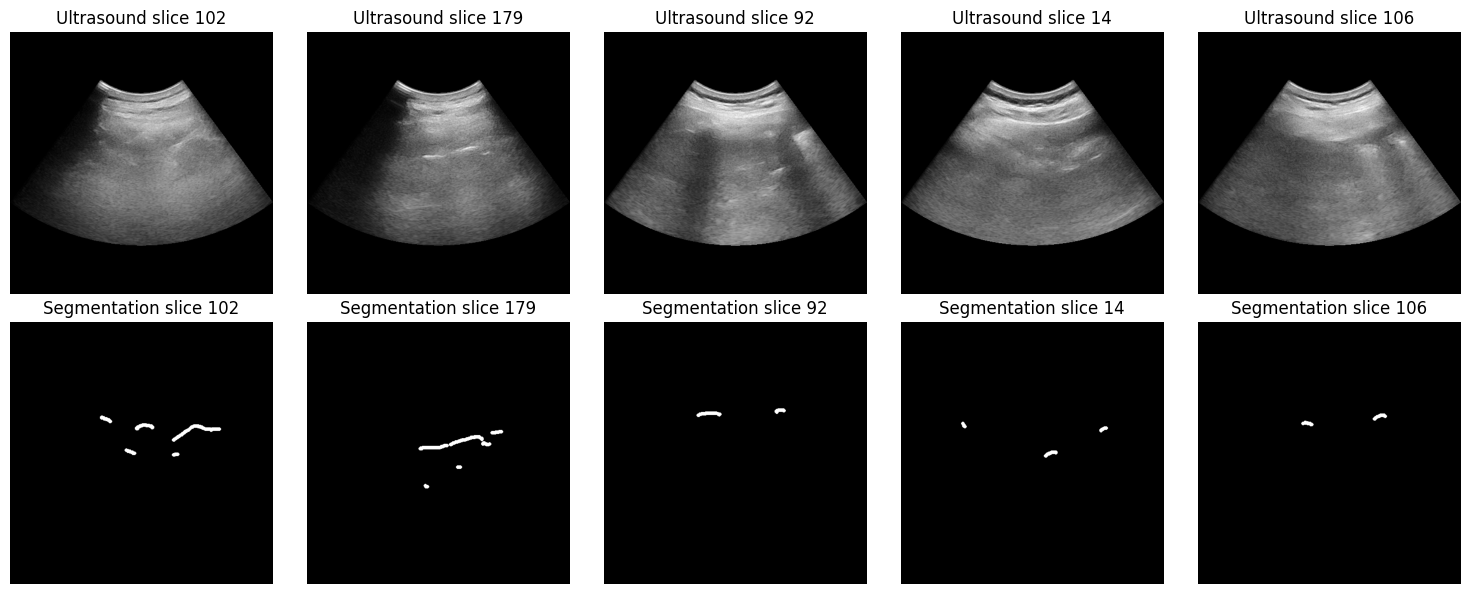

In [13]:
# Visualize a random sample of slices from the ultrasound and segmentation arrays

import matplotlib.pyplot as plt

np.random.seed(random_seed)
sample_indices = np.random.randint(0, ultrasound_array.shape[0], num_samples)
fig, axes = plt.subplots(2, num_samples, figsize=(3*num_samples, 6))
for i, index in enumerate(sample_indices):
    axes[0, i].imshow(ultrasound_array[index], cmap='gray')
    axes[0, i].set_title(f"Ultrasound slice {index}")
    axes[0, i].axis('off')
    axes[1, i].imshow(segmentation_array[index], cmap='gray')
    axes[1, i].set_title(f"Segmentation slice {index}")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()


In [14]:

# Make a df of all files in the data folders. Assume the following subfolders: images, labels, transforms.
# Inside each subfolder, files are grouped in subfolders named after the patient ID.

def get_files(data_folder, subfolder):
    files = []
    for root, dirs, filenames in tqdm(os.walk(os.path.join(data_folder, subfolder))):
        print(f"Processing {os.path.join(data_folder, subfolder)}")
        for filename in filenames:
            files.append({'filename': filename, 'patient_id': os.path.basename(root)})
    return pd.DataFrame(files)

slices_images = get_files(slices_folder, 'images')
slices_labels = get_files(slices_folder, 'labels')
slices_transforms = get_files(slices_folder, 'transforms')

print()
print(f"Number of array files: {len(array_data)}")
print()
print(f"Number of slices images:     {len(slices_images)}")
print(f"Number of slices labels:     {len(slices_labels)}")
print(f"Number of slices transforms: {len(slices_transforms)}")

2it [00:00, 1254.09it/s]


Processing i:/SpineUs/2024_Segmentation/04_Slices\images
Processing i:/SpineUs/2024_Segmentation/04_Slices\images


2it [00:00, 2001.10it/s]


Processing i:/SpineUs/2024_Segmentation/04_Slices\labels
Processing i:/SpineUs/2024_Segmentation/04_Slices\labels


2it [00:00, 1000.91it/s]

Processing i:/SpineUs/2024_Segmentation/04_Slices\transforms
Processing i:/SpineUs/2024_Segmentation/04_Slices\transforms

Number of array files: 1

Number of slices images:     201
Number of slices labels:     201
Number of slices transforms: 201


In [15]:
# Create one table from these three tables. The new table should have the following columns: patient_id, image_filename, label_filename, transform_filename.
# All image filenames and segmentation filenames start with a frame index number before "_". These frame indices should match in the same row for all filenames.

def get_frame_index(filename):
    return int(filename.split('_')[0])

slices_images['frame_index'] = slices_images['filename'].apply(get_frame_index)
slices_labels['frame_index'] = slices_labels['filename'].apply(get_frame_index)
slices_transforms['frame_index'] = slices_transforms['filename'].apply(get_frame_index)

data = pd.merge(slices_images, slices_labels, on=['patient_id', 'frame_index'], suffixes=('_image', '_label'))

print(f"Number of rows in the merged table: {len(data)}")
print(data.head())


Number of rows in the merged table: 201
        filename_image patient_id  frame_index         filename_label
0  0000_ultrasound.npy       1158            0  0000_segmentation.npy
1  0001_ultrasound.npy       1158            1  0001_segmentation.npy
2  0002_ultrasound.npy       1158            2  0002_segmentation.npy
3  0003_ultrasound.npy       1158            3  0003_segmentation.npy
4  0004_ultrasound.npy       1158            4  0004_segmentation.npy


In [16]:
# Select random patient_id and frame_index pairs from the data table. For each pair, read the image, label files into np.array format. If transforms are available, read those too.

import random

random.seed(random_seed)
sample = data.sample(n=num_samples)

# Read the first sample to obtain image width and height

sample_image = np.load(os.path.join(slices_folder, 'images', sample.iloc[0]['patient_id'], sample.iloc[0]['filename_image']))
print(f"Sample image shape: {sample_image.shape}")

print(f"Sample data:")
print(f"{sample.to_string()}")

Sample image shape: (128, 128, 1)
Sample data:
          filename_image patient_id  frame_index         filename_label
15   0015_ultrasound.npy       1158           15  0015_segmentation.npy
9    0009_ultrasound.npy       1158            9  0009_segmentation.npy
106  0106_ultrasound.npy       1158          106  0106_segmentation.npy
82   0082_ultrasound.npy       1158           82  0082_segmentation.npy
68   0068_ultrasound.npy       1158           68  0068_segmentation.npy


In [17]:
# Create numpy arrays that hold the images and segmentations

slices_images = np.zeros((num_samples, sample_image.shape[0], sample_image.shape[1], sample_image.shape[2]), dtype=np.uint8)
segmentations = np.zeros((num_samples, sample_image.shape[0], sample_image.shape[1], sample_image.shape[2]), dtype=np.uint8)

for i, (index, row) in enumerate(sample.iterrows()):
    image_filepath = os.path.join(slices_folder, 'images', row['patient_id'], row['filename_image'])
    segmentation_filepath = os.path.join(slices_folder, 'labels', row['patient_id'], row['filename_label'])
    image = np.load(image_filepath)
    segmentation = np.load(segmentation_filepath)
    slices_images[i] = image
    segmentations[i] = segmentation

print(f"Images shape:        {slices_images.shape}")
print(f"Segmentations shape: {segmentations.shape}")
print(f"Images dtype:        {slices_images.dtype}")
print(f"Segmentations dtype: {segmentations.dtype}")
print(f"Images range:        {slices_images.min()} - {slices_images.max()}")
print(f"Segmentations range: {segmentations.min()} - {segmentations.max()}")

Images shape:        (5, 128, 128, 1)
Segmentations shape: (5, 128, 128, 1)
Images dtype:        uint8
Segmentations dtype: uint8
Images range:        0 - 255
Segmentations range: 0 - 1


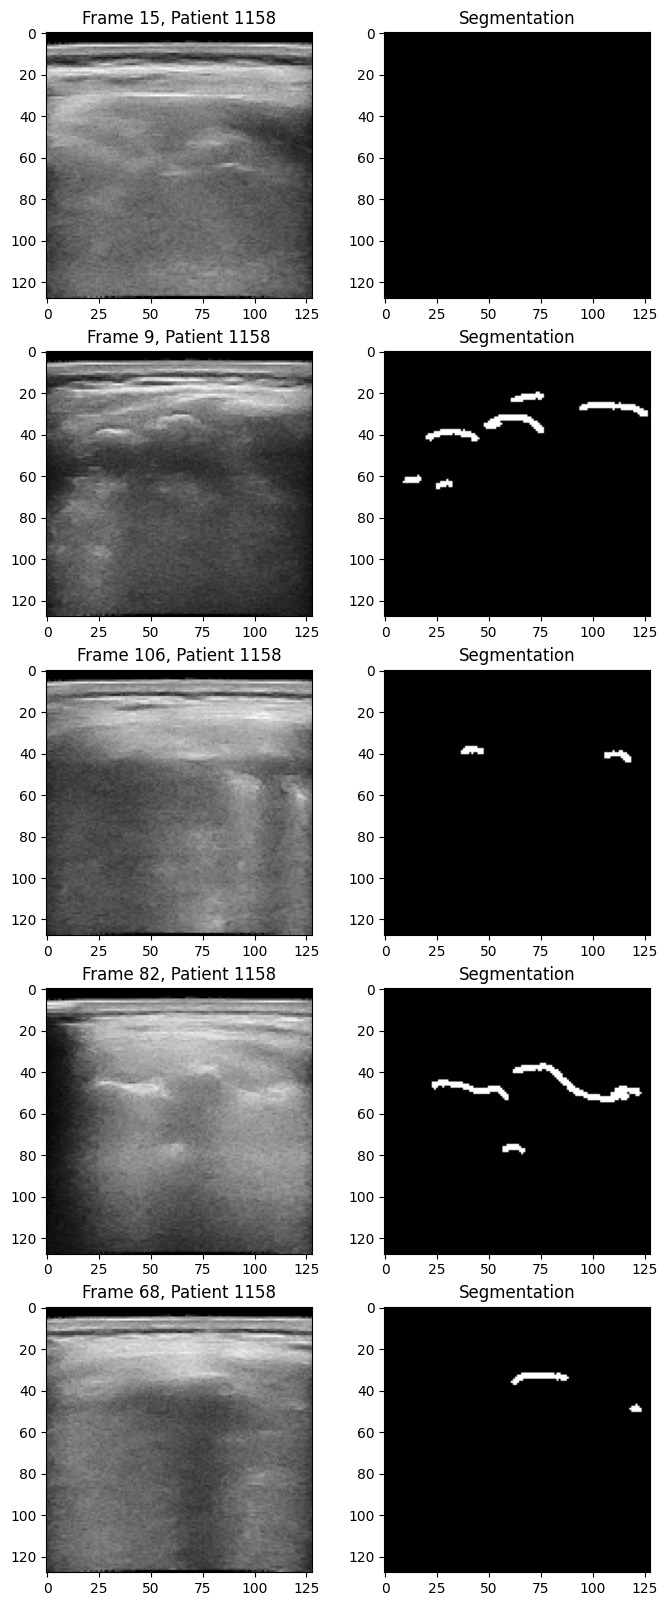

In [18]:
# Show the sample images and segmentations side by side

import matplotlib.pyplot as plt

fig, axs = plt.subplots(num_samples, 2, figsize=(8, num_samples*4))
for i in range(num_samples):
    axs[i, 0].imshow(slices_images[i, :, :, 0], cmap='gray')
    axs[i, 0].set_title(f"Frame {sample.iloc[i]['frame_index']}, Patient {sample.iloc[i]['patient_id']}")
    axs[i, 1].imshow(segmentations[i, :, :, 0], cmap='gray')
    axs[i, 1].set_title(f"Segmentation")
plt.show()